<a class="anchor" id="0"></a>
# [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction)

# Overview

In this notebook, I analyze and visualize the outliers of the NLP solution from very good notebook "[TSE2020] RoBERTa (CNN) & Random Seed Distribution"(https://www.kaggle.com/khoongweihao/tse2020-roberta-cnn-random-seed-distribution) using the functions from my notebook [NLP - EDA, Bag of Words, TF IDF, GloVe, BERT](https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert) including PCA processing, Kmeans clustering, WordCloud and others. More over I try to improve the original solution.

Add chapters "**Subtext analysis**" and "**Metric analysis**" from the commit 10.

## The best from solutions is the commit 14 (0.7175 Private LB) - bronze medal ranking.

# Results of analysis:
1. Outlier analysis of the best solutions on basic roBERTa - pls. see https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/155419
2. Analysis of the predictions with the worst score=0 from roBERTa - pls. see https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/155616
3. New (commit 22): **analysis of 3 or more repetitions of characters in words**

## Acknowledgements
* [NLP - EDA, Bag of Words, TF IDF, GloVe, BERT](https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert)
* [COVID-19 (Week5) Global Forecasting - EDA&ExtraTR](https://www.kaggle.com/vbmokin/covid-19-week5-global-forecasting-eda-extratr)
* [TSE2020] RoBERTa (CNN) & Random Seed Distribution (https://www.kaggle.com/khoongweihao/tse2020-roberta-cnn-random-seed-distribution)
* Chris Deotte's post: https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/142404#809872
* [Faster (2x) TF roBERTa](https://www.kaggle.com/seesee/faster-2x-tf-roberta)
* Many thanks to Chris Deotte for his TF roBERTa dataset at https://www.kaggle.com/cdeotte/tf-roberta
* https://www.kaggle.com/abhishek/roberta-inference-5-folds

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Import libraries](#1)
1. [Download data & FE](#2)
1. [Model tuning](#3)
   - [My upgrade of parameters](#3.1)
   - [Model training](#3.2)
1. [Submission](#4)
1. [Outlier analysis](#5)
    - [Training prediction result visualization](#5.1)
    - [WordCloud](#5.2)
    - [Subtext analysis](#5.3)
    - [Metric analysis](#5.4)
    - [PCA visualization](#5.5)
    - [Clustering](#5.6)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns; sns.set(style='white')
from mpl_toolkits.mplot3d import Axes3D

from wordcloud import WordCloud
from sklearn.decomposition import PCA, TruncatedSVD
import math
import pickle

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras.backend as K
from transformers import *
import tokenizers
from sklearn.model_selection import StratifiedKFold

pd.set_option('max_colwidth', 40)

## 2. Download data & FE <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

Code from notebook https://www.kaggle.com/khoongweihao/tse2020-roberta-cnn-random-seed-distribution?scriptVersionId=34448972

In [2]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
EPOCHS = 3 # originally 3
BATCH_SIZE = 32 # originally 32
PAD_ID = 1
SEED = 88888
LABEL_SMOOTHING = 0.1
tf.random.set_seed(SEED)
np.random.seed(SEED)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative


In [3]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask_t[k,:len(enc.ids)+3] = 1

## 3. Model tuning <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

## 3.1. My upgrade of parameters <a class="anchor" id="3.1"></a>

[Back to Table of Contents](#0.1)

In [4]:
Dropout_new = 0.15     # originally 0.1
n_split = 5            # originally 5
lr = 3e-5              # originally 3e-5

## Previous successful commits

### Commit 3 (with original parameters)

* Dropout_new = 0.1
* n_split = 5
* lr = 3e-5

LB = 0.711

### Commit 5

* Dropout_new = 0.15
* n_split = 5
* lr = 3e-5

LB = 0.713

### Commit 6

* Dropout_new = 0.15
* n_split = 7
* lr = 3e-5

LB = 0.709

### Commit 7

* Dropout_new = 0.15
* n_split = 5
* lr = 4e-5

LB = 0.709

### Commit 8

* Dropout_new = 0.15
* n_split = 5
* lr = 2e-5

LB = 0.712

### Commit 9

* Dropout_new = 0.15
* n_split = 5
* lr = 3e-5
* LeakyReLU_alpha=0.05

LB = 0.711

### Commit 10

* Dropout_new = 0.15
* n_split = 5
* lr = 3e-5
* LeakyReLU_alpha=0.3

LB = 0.711

### Commit 12

* Dropout_new = 0.15
* n_split = 5
* lr = 3e-5
* SEED = 42

LB = 0.711

### Commit 13

* Dropout_new = 0.16
* n_split = 5
* lr = 3e-5

LB = 0.711

### Commit 14

* Dropout_new = 0.15
* n_split = 5
* lr = 3e-5

**LB = 0.715 (the best)**

### Commit 15

* Dropout_new = 0.16
* n_split = 5
* lr = 3e-5
* SEED = 777

LB = 0.710

### Commit 17

* Dropout_new = 0.15
* n_split = 5
* lr = 1e-5

LB = 0.709

### Commit 18

* Dropout_new = 0.15
* n_split = 5
* lr = 3e-5
* BATCH_SIZE = 24      # originally 32

LB = 0.704

### Commit 19

* Dropout_new = 0.125
* n_split = 5
* lr = 3e-5

LB = 0.711

### Commit 20

* Dropout_new = 0.15
* n_split = 5
* lr = 1e-4

LB = 0.709

### Commit 21

* Dropout_new = 0.15
* n_split = 5
* lr = 1e-4
* num_cnn2 = 96          # originally 64

LB = 0.712

## 3.2. Model training <a class="anchor" id="3.2"></a>

[Back to Table of Contents](#0.1)

Code from notebook https://www.kaggle.com/khoongweihao/tse2020-roberta-cnn-random-seed-distribution?scriptVersionId=34448972

**Upgrade:** add prediction for training data for Outlier analysis and parameters tuning

In [5]:
import pickle

def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)


def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model

def loss_fn(y_true, y_pred):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss


def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN - tf.reduce_sum(padding, -1)
    max_len = tf.reduce_max(lens)
    ids_ = ids[:, :max_len]
    att_ = att[:, :max_len]
    tok_ = tok[:, :max_len]

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids_,attention_mask=att_,token_type_ids=tok_)
    
    x1 = tf.keras.layers.Dropout(Dropout_new)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(Dropout_new)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
    return model, padded_model

In [6]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [7]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+3] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

In [8]:
%%time
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start_train = np.zeros((input_ids.shape[0],MAX_LEN))
preds_end_train = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
        
    #sv = tf.keras.callbacks.ModelCheckpoint(
    #    '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #    save_weights_only=True, mode='auto', save_freq='epoch')
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    #weight_fn = '%s-roberta-%i.h5'%(VER,fold)
    for epoch in range(1, EPOCHS + 1):
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, callbacks=[],
            validation_data=(inpV, targetV), shuffle=False)  # don't shuffle in `fit`
        #save_weights(model, weight_fn)

    #print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    #load_weights(model, weight_fn)

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting all Train for Outlier analysis...')
    preds_train = padded_model.predict([input_ids,attention_mask,token_type_ids],verbose=DISPLAY)
    preds_start_train += preds_train[0]/skf.n_splits
    preds_end_train += preds_train[1]/skf.n_splits

    print('Predicting Test...')
    preds = padded_model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################
Train on 21984 samples, validate on 5497 samples
21984/21984 [==============================] - 129s 6ms/sample - loss: 2.8822 - activation_loss: 1.4557 - activation_1_loss: 1.4265 - val_loss: 2.5379 - val_activation_loss: 1.2778 - val_activation_1_loss: 1.2612
Train on 21984 samples, validate on 5497 samples
Epoch 2/2
21984/21984 [==============================] - 103s 5ms/sample - loss: 2.5349 - activation_loss: 1.2891 - activation_1_loss: 1.2458 - val_loss: 2.5091 - val_activation_loss: 1.2795 - val_activation_1_loss: 1.2307
Train on 21984 samples, validate on 5497 samples
Epoch 3/3
21984/21984 [==============================] - 103s 5ms/sample - loss: 2.4081 - activation_loss: 1.2258 - activation_1_loss: 1.1823 - val_loss: 2.5335 - val_activation_loss: 1.2906 - val_activation_1_loss: 1.2443
Predicting OOF...
5497/5497 [==============================] - 16s 3ms/sample
Predicting all Train for Outlier analysis...
27481/27

In [9]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))
print(jac) # Jaccard CVs

>>>> OVERALL 5Fold CV Jaccard = 0.7061890909521937
[0.7117922791929515, 0.7105030975888511, 0.7062925773655861, 0.6988846666710836, 0.7034728339424959]


## 4. Submission <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

Code from notebook https://www.kaggle.com/khoongweihao/tse2020-roberta-cnn-random-seed-distribution?scriptVersionId=34448972

In [10]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
    all.append(st)

In [11]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
test.sample(10)

,textID,text,sentiment,selected_text
1191,12005b65fc,Waiting for my turn on wii fit gym c...,neutral,waiting for my turn on wii fit gym ...
661,bcf13877f7,Good morning everyone,positive,good morning everyone
1968,575e4a89fe,tts ridiculously sweet of you,positive,ridiculously sweet of you
826,a0b1828b67,'Brides a la mode' pow wow first thi...,positive,lovely
992,472c3e2c41,Getting somewhere with my first 'rea...,neutral,getting somewhere with my first 're...
1922,ce71d002ec,Mommas day is may 10th! Don`t forget...,positive,nice
1043,8db4aaef4a,watching the notebook,neutral,watching the notebook
2111,895de1648c,really tired. and have to work the w...,negative,really tired.
1695,78d89e7c64,Yeah prbly pickin up songs for Sing...,neutral,yeah prbly pickin up songs for sing...
2220,756d255e40,is at home with a pukey boy! Poor li...,negative,poor little baby


## 5. Outlier analysis <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

## 5.1. Training prediction result visualization <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

In [12]:
# Visualization training prediction results
all = []
start = []
end = []
start_pred = []
end_pred = []
for k in range(input_ids.shape[0]):
    a = np.argmax(preds_start_train[k,])
    b = np.argmax(preds_end_train[k,])
    start.append(np.argmax(start_tokens[k]))
    end.append(np.argmax(end_tokens[k]))        
    if a>b:
        st = train.loc[k,'text']
        start_pred.append(0)
        end_pred.append(len(st))
    else:
        text1 = " "+" ".join(train.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
        start_pred.append(a)
        end_pred.append(b)
    all.append(st)
train['start'] = start
train['end'] = end
train['start_pred'] = start_pred
train['end_pred'] = end_pred
train['selected_text_pred'] = all
train.sample(10)

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred
21735,98bfec52ab,"yay, you get to ride on the tow tru...","yay, you get to ride on the tow truc...",neutral,2,18,2,18,"yay, you get to ride on the tow tru..."
879,edd0fa3494,okay okay sleep for realz now! Goodn...,Goodnight!,positive,10,12,10,12,goodnight!
17192,6f3ca88a83,I wish.,I wish.,neutral,2,4,2,4,i wish.
2645,4d2e0f9522,"And the city I love, Tucson, is the ...","And the city I love, Tucson, is the ...",neutral,2,17,2,17,"and the city i love, tucson, is the..."
15125,8e4c70c9fe,HA ha - how much? Thanks for start...,Thanks for starting to follow me.,positive,8,14,8,8,thanks
22629,34e9079641,"So much to do this summer, hopefully...",hopefully all comes in favor,positive,9,13,9,9,hopefully
3864,6064742680,P-Nutt got a new collar and leash to...,P-Nutt got a new collar and leash today,neutral,2,12,2,30,p-nutt got a new collar and leash t...
18067,97670f1527,at least two to three times a week i...,at least two to three times a week i...,neutral,2,30,2,30,at least two to three times a week ...
7485,29dbb23bed,Two fantastic shows in a row,fantastic,positive,3,3,3,3,fantastic
18719,0bf00d3823,thank God we finally found her!,thank God we,positive,2,4,2,3,thank god


In [13]:
def metric_tse(df,col1,col2):
    # Calc metric of tse-competition - according to https://www.kaggle.com/c/tweet-sentiment-extraction/overview/evaluation
    return df.apply(lambda x: jaccard(x[col1],x[col2]),axis=1)

In [14]:
# Analytics
train = train.replace({'sentiment': {'negative': -1, 'neutral': 0, 'positive': 1}})
train['len_text'] = train['text'].str.len()
train['len_selected_text'] = train['selected_text'].str.len()
train['diff_num'] = train['end']-train['start']
train['share'] = train['len_selected_text']/train['len_text']

In [15]:
# Prediction analytics
train['selected_text_pred'] = train['selected_text_pred'].map(lambda x: x.lstrip(' '))
train['len_selected_text_pred'] = train['selected_text_pred'].str.len()
train['diff_num_pred'] = train['end_pred']-train['start_pred']
train['share_pred'] = train['len_selected_text_pred']/train['len_text']
# len_equal
train['len_equal'] = 0
train.loc[(train['start'] == train['start_pred']) & (train['end'] == train['end_pred']), 'len_equal'] = 1
# metric
train['metric'] = metric_tse(train,'selected_text','selected_text_pred')
# res
train['res'] = 0
train.loc[train['metric'] == 1, 'res'] = 1

In [16]:
def rep_3chr(text):
    # Checks if there are 3 or more repetitions of characters in words
    chr3 = 0
    for word in text.split():
        for c in set(word):
            if word.rfind(c+c+c) > -1:
                chr3 = 1                
    return chr3

In [17]:
# Analysis of 3 or more repetitions of characters in words
train['text_chr3'] = train['text'].apply(rep_3chr)
train['selected_text_chr3'] = train['selected_text'].apply(rep_3chr)
train['selected_text_pred_chr3'] = train['selected_text_pred'].apply(rep_3chr)

In [18]:
# result
col_interesting = ['sentiment', 'len_text', 'text_chr3', 'selected_text', 'len_selected_text', 'diff_num', 'share', 
                   'selected_text_chr3', 'selected_text_pred', 'len_selected_text_pred', 'diff_num_pred', 'share_pred',
                   'selected_text_pred_chr3', 'len_equal', 'metric', 'res']
train[col_interesting].head(10)

,sentiment,len_text,text_chr3,selected_text,len_selected_text,diff_num,share,selected_text_chr3,selected_text_pred,len_selected_text_pred,diff_num_pred,share_pred,selected_text_pred_chr3,len_equal,metric,res
0,0,36,0,"I`d have responded, if I were going",35,9,0.972222,0,"i`d have responded, if i were going",35,9,0.972222,0,1,1.000000,1
1,-1,46,1,Sooo SAD,8,2,0.173913,1,sooo sad,8,2,0.173913,1,1,1.000000,1
2,-1,25,1,bullying me,11,1,0.440000,0,bullying me...,14,2,0.560000,1,0,0.333333,0
3,-1,31,0,leave me alone,14,2,0.451613,0,leave me alone,14,2,0.451613,0,1,1.000000,1
4,-1,75,1,"Sons of ****,",13,3,0.173333,1,"sons of ****,",13,3,0.173333,1,1,1.000000,1
5,0,92,1,http://www.dothebouncy.com/smf - som...,92,26,1.000000,1,http://www.dothebouncy.com/smf - som...,92,26,1.000000,1,1,1.000000,1
6,1,64,0,fun,3,0,0.046875,0,fun,3,0,0.046875,0,1,1.000000,1
7,0,10,1,Soooo high,10,2,1.000000,1,soooo high,10,2,1.000000,1,1,1.000000,1
8,0,12,0,Both of you,11,2,0.916667,0,both of you,11,2,0.916667,0,1,1.000000,1
9,1,69,1,Wow... u just became cooler.,28,6,0.405797,1,wow... u just became cooler.,28,6,0.405797,1,1,1.000000,1


In [19]:
print('Total metric =',train['metric'].mean())

Total metric = 0.7708659944714187


In [20]:
train.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27480.000000,27481.000000,27481.000000,27480.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000,27481.000000
mean,0.029147,6.157272,14.784396,6.254066,14.502092,68.327535,36.705287,8.627124,0.583541,34.533496,8.248026,0.551031,0.651286,0.770866,0.636367,0.267603,0.143044,0.154616
std,0.771104,6.874129,9.423494,6.977835,10.116991,35.605608,35.661991,9.410159,0.403266,36.184753,10.321117,0.414892,0.476572,0.341218,0.481054,0.442718,0.350124,0.361545
min,-1.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.008929,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,7.000000,2.000000,6.000000,39.000000,8.000000,1.000000,0.148148,7.000000,1.000000,0.113636,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,13.000000,2.000000,12.000000,64.000000,22.000000,5.000000,0.632456,18.000000,4.000000,0.483871,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,8.000000,21.000000,8.000000,21.000000,97.000000,55.000000,13.000000,1.000000,52.000000,13.000000,0.987342,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,49.000000,81.000000,53.000000,138.000000,141.000000,141.000000,79.000000,1.000000,140.000000,138.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Long 'selected text' are not predicted correctly (get too long)

In [21]:
# Outlier
train_outlier = train[train['res'] == 0].reset_index(drop=True)
train_outlier

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
0,088c60f138,my boss is bullying me...,bullying me,-1,5,6,5,7,bullying me...,25,...,0.440000,14,2,0.560000,0,0.333333,0,1,0,1
1,74a76f6e0a,My Sharpie is running DANGERously lo...,DANGERously,-1,7,7,7,10,dangerously low on ink,44,...,0.250000,22,3,0.500000,0,0.250000,0,0,0,0
2,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",-1,2,9,7,9,sunburned,21,...,1.000000,9,2,0.428571,0,0.200000,0,0,0,0
3,af3fed7fc3,is back home now gonna miss eve...,onna,-1,6,6,7,7,miss,42,...,0.095238,4,0,0.095238,0,0.000000,0,0,0,0
4,e00c6ef376,the free fillin` app on my ipod is f...,the free fillin` app on my ipod is f...,1,2,16,13,14,"fun,",51,...,1.000000,4,1,0.078431,0,0.090909,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,4eac33d1c0,wish we could come see u on Denver ...,d lost,-1,11,12,12,12,lost,77,...,0.077922,4,0,0.051948,0,0.500000,0,0,0,0
9989,4f4c4fc327,I`ve wondered about rake to. The c...,", don`t force",-1,19,23,20,23,don`t force,122,...,0.106557,11,3,0.090164,0,0.666667,0,0,0,0
9990,f67aae2310,Yay good for both of you. Enjoy the...,Yay good for both of you.,1,2,9,2,4,yay good,111,...,0.225225,8,2,0.072072,0,0.333333,0,1,0,0
9991,ed167662a5,But it was worth it ****.,But it was worth it ****.,1,2,8,5,5,worth,27,...,0.962963,5,0,0.185185,0,0.200000,0,1,1,0


In [22]:
train_outlier.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9992.000000,9993.000000,9993.000000,9992.000000,9993.000000,9993.000000,9993.0,9993.000000,9993.000000,9993.000000
mean,0.051436,8.376764,14.931752,8.643751,14.129691,74.753928,29.023116,6.554988,0.424663,23.372761,5.485940,0.340174,0.047633,0.369876,0.0,0.311918,0.111578,0.142700
std,0.943116,7.690693,9.043958,7.862381,10.815691,34.290988,28.935075,7.448489,0.338861,29.384792,9.874859,0.337213,0.213000,0.259821,0.0,0.463300,0.314862,0.349784
min,-1.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.008929,0.000000,0.000000,0.016949,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,7.000000,2.000000,6.000000,46.000000,9.000000,1.000000,0.133998,6.000000,0.000000,0.083810,0.000000,0.166667,0.0,0.000000,0.000000,0.000000
50%,0.000000,5.000000,13.000000,6.000000,12.000000,72.000000,18.000000,4.000000,0.302326,10.000000,2.000000,0.178082,0.000000,0.333333,0.0,0.000000,0.000000,0.000000
75%,1.000000,13.000000,21.000000,13.000000,20.000000,103.000000,37.000000,9.000000,0.722664,26.000000,6.000000,0.510638,0.000000,0.500000,0.0,1.000000,0.000000,0.000000
max,1.000000,48.000000,52.000000,53.000000,138.000000,140.000000,138.000000,46.000000,1.000000,138.000000,138.000000,1.000000,1.000000,0.960000,0.0,1.000000,1.000000,1.000000


In [23]:
sh_out = str(round(len(train_outlier)*100/len(train),1))
print('Number of outliers is ' + sh_out + '% from training data')

Number of outliers is 36.4% from training data


In [24]:
# Good prediction
train_good = train[train['res'] == 1].reset_index(drop=True)
train_good

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0,2,11,2,11,"i`d have responded, if i were going",36,...,0.972222,35,9,0.972222,1,1.0,1,0,0,0
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,-1,2,4,2,4,sooo sad,46,...,0.173913,8,2,0.173913,1,1.0,1,1,1,1
2,9642c003ef,what interview! leave me alone,leave me alone,-1,5,7,5,7,leave me alone,31,...,0.451613,14,2,0.451613,1,1.0,1,0,0,0
3,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",-1,2,5,2,5,"sons of ****,",75,...,0.173333,13,3,0.173333,1,1.0,1,1,1,1
4,28b57f3990,http://www.dothebouncy.com/smf - som...,http://www.dothebouncy.com/smf - som...,0,2,28,2,28,http://www.dothebouncy.com/smf - som...,92,...,1.000000,92,26,1.000000,1,1.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17483,a753a93e45,"few grilled mushrooms and olives, fe...","few grilled mushrooms and olives, fe...",0,2,24,2,24,"few grilled mushrooms and olives, fe...",101,...,1.000000,101,22,1.000000,1,1.0,1,0,0,0
17484,ac92790d8b,94 more days till BH comes back to LA,94 more days till BH comes back to LA,0,2,11,2,11,94 more days till bh comes back to la,37,...,1.000000,37,9,1.000000,1,1.0,1,0,0,0
17485,15bb120f57,i`m defying gravity. and nobody in a...,i`m defying gravity. and nobody in a...,0,2,30,2,30,i`m defying gravity. and nobody in a...,106,...,1.000000,106,28,1.000000,1,1.0,1,1,1,1
17486,a208770a32,in spoke to you yesterday and u did...,in spoke to you yesterday and u didn...,0,2,15,2,15,in spoke to you yesterday and u didn...,67,...,0.985075,65,13,0.970149,1,1.0,1,0,0,0


In [25]:
train_good.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.0,17488.0,17488.000000,17488.000000,17488.000000
mean,0.016411,4.889010,14.700194,4.888552,14.714890,64.655364,41.095037,9.811185,0.674318,40.910968,9.826338,0.671508,0.996226,1.0,1.0,0.242280,0.161025,0.161425
std,0.652460,6.003085,9.632900,6.005353,9.689054,35.822481,38.303373,10.178266,0.408995,38.109368,10.238673,0.406944,0.061319,0.0,0.0,0.428475,0.367564,0.367933
min,-1.000000,2.000000,2.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.021739,1.000000,0.000000,0.021739,0.000000,1.0,1.0,0.000000,0.000000,0.000000
25%,0.000000,2.000000,7.000000,2.000000,7.000000,35.000000,8.000000,1.000000,0.164384,8.000000,1.000000,0.164384,1.000000,1.0,1.0,0.000000,0.000000,0.000000
50%,0.000000,2.000000,12.000000,2.000000,12.000000,59.000000,27.000000,6.000000,0.978022,27.000000,6.000000,0.970588,1.000000,1.0,1.0,0.000000,0.000000,0.000000
75%,0.000000,5.000000,21.000000,5.000000,21.000000,93.000000,65.000000,16.000000,1.000000,65.000000,16.000000,1.000000,1.000000,1.0,1.0,0.000000,0.000000,0.000000
max,1.000000,49.000000,81.000000,49.000000,99.000000,141.000000,141.000000,79.000000,1.000000,140.000000,99.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000


Share of all data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f200002a050>,
      dtype=object)

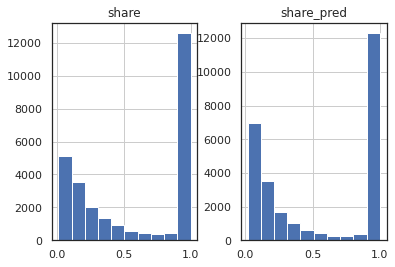

In [26]:
print('Share of all data')
train[['share', 'share_pred']].hist(bins=10)

Share of outlier data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd8e950d0>,
      dtype=object)

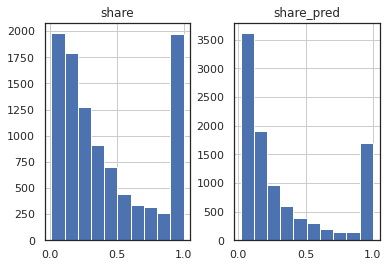

In [27]:
print('Share of outlier data')
train_outlier[['share', 'share_pred']].hist(bins=10)

The main problem is in the predicting of the longest and shortest selected_text which are most or least different from the given text

In [28]:
# Only one word in 'selected_text'
train_outlier[train_outlier['diff_num']==0]

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
1,74a76f6e0a,My Sharpie is running DANGERously lo...,DANGERously,-1,7,7,7,10,dangerously low on ink,44,...,0.250000,22,3,0.500000,0,0.250000,0,0,0,0
3,af3fed7fc3,is back home now gonna miss eve...,onna,-1,6,6,7,7,miss,42,...,0.095238,4,0,0.095238,0,0.000000,0,0,0,0
20,90a2cdb657,What better way to spoil mum than to...,favorite,1,25,25,2,25,what better way to spoil mum than to...,135,...,0.059259,110,23,0.814815,0,0.050000,0,0,0,0
23,a4e00d4d26,a celtics-lakers rematch sounds bet...,better,1,11,11,10,11,sounds better,60,...,0.100000,13,1,0.216667,0,0.500000,0,0,0,0
25,58d382e07a,lucky kid...i so wanna see loservil...,lucky,1,2,2,2,4,lucky kid...,57,...,0.087719,12,2,0.210526,0,0.500000,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,a3c03380ec,courtney seems like a cool chick & ...,pretty,1,12,12,7,12,cool chick & shes pretty,47,...,0.127660,24,5,0.510638,0,0.200000,0,0,0,0
9955,7523a28376,hey you weirdo! haha jk! I love you!,love,1,12,12,11,12,i love,37,...,0.108108,6,1,0.162162,0,0.500000,0,0,0,0
9972,413195db27,Is wondering what happened to the su...,****,-1,10,10,10,13,**** may grey!,53,...,0.075472,14,3,0.264151,0,0.333333,0,1,1,1
9982,c37b979e7e,again thanks to my dear neighboor w...,thanks,1,3,3,3,23,thanks to my dear neighboor who also...,92,...,0.065217,85,20,0.923913,0,0.055556,0,0,0,0


In [29]:
train_good[train_good['diff_num']==0]

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
5,6e0c6d75b1,2am feedings for the baby are fun wh...,fun,1,10,10,10,10,fun,64,...,0.046875,3,0,0.046875,1,1.0,1,0,0,0
10,16fab9f95b,I really really like the song Love S...,like,1,5,5,5,5,like,56,...,0.071429,4,0,0.071429,1,1.0,1,0,0,0
11,04dd1d2e34,i want to go to music tonight but i ...,lost,-1,11,11,11,11,lost,50,...,0.080000,4,0,0.080000,1,1.0,1,0,0,0
14,919fa93391,i`ve been sick for the past few days...,sick,-1,6,6,6,6,sick,137,...,0.029197,4,0,0.029197,1,1.0,1,1,0,0
22,6ce4a4954b,juss came backk from Berkeleyy ; omg...,fun,1,17,17,17,17,fun,109,...,0.027523,3,0,0.027523,1,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17477,13e1519ce3,"good as, cya in melbourne",good,1,2,2,2,2,good,27,...,0.148148,4,0,0.148148,1,1.0,1,0,0,0
17479,a38bf809b0,LIKE DREW SAID 'GIVE TC A CHANCE' W...,MISS,-1,13,13,13,13,miss,111,...,0.036036,4,0,0.036036,1,1.0,1,0,0,0
17480,c14a543497,Sure. I`ll try n keep that up! =P Y...,enjoy,1,16,16,16,16,enjoy,59,...,0.084746,5,0,0.084746,1,1.0,1,0,0,0
17482,432e6de6c9,morning twit-friends! welcome to my ...,welcome,1,8,8,8,8,welcome,49,...,0.142857,7,0,0.142857,1,1.0,1,0,0,0


In [30]:
# 'selected_text' = 'text'
train_outlier[train_outlier['share']==1]

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
2,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",-1,2,9,7,9,sunburned,21,...,1.0,9,2,0.428571,0,0.200000,0,0,0,0
4,e00c6ef376,the free fillin` app on my ipod is f...,the free fillin` app on my ipod is f...,1,2,16,13,14,"fun,",51,...,1.0,4,1,0.078431,0,0.090909,0,0,0,0
24,0a61cbf4b5,I am sooo tired,I am sooo tired,-1,2,6,6,6,tired,15,...,1.0,5,0,0.333333,0,0.250000,0,1,1,0
27,3d2fcd78c8,Happy Star Wars day everyone! and En...,Happy Star Wars day everyone! and En...,1,2,14,2,2,happy,56,...,1.0,5,0,0.089286,0,0.100000,0,0,0,0
32,4c41a35a2a,Happy Mothers day to all you Mums ou...,Happy Mothers day to all you Mums ou...,1,2,11,2,2,happy,43,...,1.0,5,0,0.116279,0,0.111111,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,e07daddcc5,i have a crush on someone!,i have a crush on someone!,1,2,8,5,5,crush,26,...,1.0,5,0,0.192308,0,0.166667,0,0,0,0
9962,9ff61fee3b,Glad to see and more Red Bull Air R...,Glad to see and more Red Bull Air R...,1,2,17,2,2,glad,69,...,1.0,4,0,0.057971,0,0.066667,0,0,0,0
9968,0d46954e4d,WHY DO I EVEN TRY... WHEN DEEP DOWN ...,WHY DO I EVEN TRY... WHEN DEEP DOWN ...,-1,2,20,16,16,pain,77,...,1.0,4,0,0.051948,0,0.062500,0,1,1,0
9969,2151413f96,ish okay my loveee,ish okay my loveee,1,2,7,6,7,loveee,18,...,1.0,6,1,0.333333,0,0.250000,0,1,1,1


In [31]:
train_good[train_good['share']==1]

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
4,28b57f3990,http://www.dothebouncy.com/smf - som...,http://www.dothebouncy.com/smf - som...,0,2,28,2,28,http://www.dothebouncy.com/smf - som...,92,...,1.0,92,26,1.0,1,1.0,1,1,1,1
6,50e14c0bb8,Soooo high,Soooo high,0,2,4,2,4,soooo high,10,...,1.0,10,2,1.0,1,1.0,1,1,1,1
12,bbe3cbf620,test test from the LG enV2,test test from the LG enV2,0,2,9,2,9,test test from the lg env2,26,...,1.0,26,7,1.0,1,1.0,1,0,0,0
15,40e7becabf,Hes just not that into you,Hes just not that into you,0,2,7,2,7,hes just not that into you,26,...,1.0,26,5,1.0,1,1.0,1,0,0,0
18,7de057cf40,is cleaning the house for her family...,is cleaning the house for her family...,0,2,15,2,15,is cleaning the house for her family...,65,...,1.0,65,13,1.0,1,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17473,a01e5d1ddf,it`s beeen onee year,it`s beeen onee year,0,2,9,2,9,it`s beeen onee year,20,...,1.0,20,7,1.0,1,1.0,1,1,1,1
17478,17c8c317f0,Scream just played on my iPod. First...,Scream just played on my iPod. First...,0,2,21,2,21,scream just played on my ipod. first...,87,...,1.0,87,19,1.0,1,1.0,1,1,1,1
17483,a753a93e45,"few grilled mushrooms and olives, fe...","few grilled mushrooms and olives, fe...",0,2,24,2,24,"few grilled mushrooms and olives, fe...",101,...,1.0,101,22,1.0,1,1.0,1,0,0,0
17484,ac92790d8b,94 more days till BH comes back to LA,94 more days till BH comes back to LA,0,2,11,2,11,94 more days till bh comes back to la,37,...,1.0,37,9,1.0,1,1.0,1,0,0,0


In [32]:
# Only one word in 'text'
train_outlier[train_outlier["text"].str.find(' ') == -1].head(5)

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
99,fdb77c3752,,,0,2,2,2,2,,0,...,NaN,0,0,NaN,1,0.5,0,0,0,0
475,bc84f21e3b,ShoesShoesShoes.YayYayYay.lol.IWould...,ShoesShoesShoes.YayYayYay.lol.I,1,2,18,9,15,yayyayyay.,63,...,0.492063,10,6,0.15873,0,0.0,0,0,0,0
6039,320d33101f,goodnight!!!,goodnight!!,1,2,4,2,4,goodnight!!!,12,...,0.916667,12,2,1.00000,1,0.0,0,1,0,1
8849,bbe7ecfac4,BYEEEEE!!!,BYEEEEE!!,0,2,5,2,5,byeeeee!!!,10,...,0.900000,10,3,1.00000,1,0.0,0,1,1,1
9344,f7286fdad8,@_Cheshire_Cat_,_Cheshire_Cat_,0,3,8,2,8,@_cheshire_cat_,15,...,0.933333,15,6,1.00000,0,0.0,0,0,0,0


In [33]:
len(train_outlier[train_outlier["text"].str.find(' ') == -1])

5

In [34]:
train_good[train_good["text"].str.find(' ') == -1].head(5)

,textID,text,selected_text,sentiment,start,end,start_pred,end_pred,selected_text_pred,len_text,...,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
29,2e7082d1c8,MAYDAY?!,MAYDAY?!,0,2,4,2,4,mayday?!,8,...,1.0,8,2,1.0,1,1.0,1,0,0,0
45,fa2654e730,Chilliin,Chilliin,1,2,4,2,4,chilliin,8,...,1.0,8,2,1.0,1,1.0,1,0,0,0
152,f3a77c2b5e,_nesmith,_nesmith,0,2,4,2,4,_nesmith,8,...,1.0,8,2,1.0,1,1.0,1,0,0,0
223,0404648e1c,?sucks!?..,?sucks!?..,-1,2,6,2,6,?sucks!?..,10,...,1.0,10,4,1.0,1,1.0,1,0,0,0
265,47990d2312,BRAINFREEZE,BRAINFREEZE,0,2,4,2,4,brainfreeze,11,...,1.0,11,2,1.0,1,1.0,1,0,0,0


In [35]:
len(train_good[train_good["text"].str.find(' ') == -1])

58

Text from a single word almost always processes correctly

## 5.2. WordCloud <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

Using my notebook https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

In [36]:
def plot_word_cloud(x, col):
    corpus=[]
    for k in x[col].str.split():
        for i in k:
            corpus.append(i)
    plt.figure(figsize=(12,8))
    word_cloud = WordCloud(
                              background_color='black',
                              max_font_size = 80
                             ).generate(" ".join(corpus[:50]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()
    return corpus[:50]

Word Cloud for all text in training data


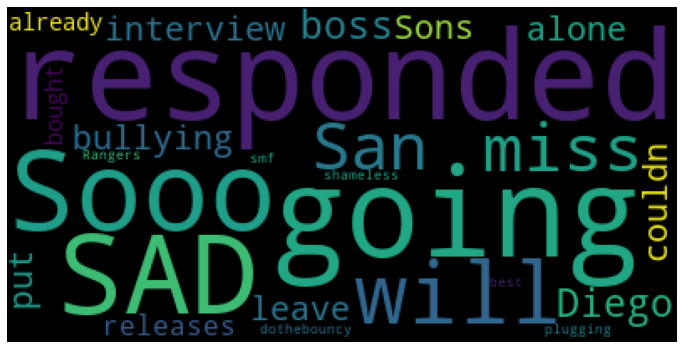

In [37]:
# All training text
print('Word Cloud for all text in training data')
train_all = plot_word_cloud(train, 'text')

In [38]:
train_all

['I`d',
 'have',
 'responded,',
 'if',
 'I',
 'were',
 'going',
 'Sooo',
 'SAD',
 'I',
 'will',
 'miss',
 'you',
 'here',
 'in',
 'San',
 'Diego!!!',
 'my',
 'boss',
 'is',
 'bullying',
 'me...',
 'what',
 'interview!',
 'leave',
 'me',
 'alone',
 'Sons',
 'of',
 '****,',
 'why',
 'couldn`t',
 'they',
 'put',
 'them',
 'on',
 'the',
 'releases',
 'we',
 'already',
 'bought',
 'http://www.dothebouncy.com/smf',
 '-',
 'some',
 'shameless',
 'plugging',
 'for',
 'the',
 'best',
 'Rangers']

Word Cloud for all text in test


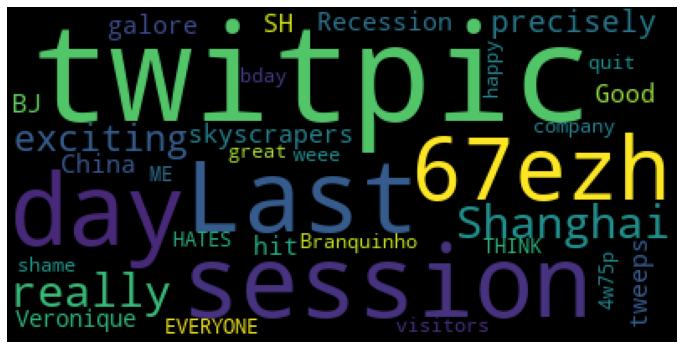

In [39]:
# All test
print('Word Cloud for all text in test')
test_all = plot_word_cloud(test, 'text')

In [40]:
test_all

['Last',
 'session',
 'of',
 'the',
 'day',
 'http://twitpic.com/67ezh',
 'Shanghai',
 'is',
 'also',
 'really',
 'exciting',
 '(precisely',
 '--',
 'skyscrapers',
 'galore).',
 'Good',
 'tweeps',
 'in',
 'China:',
 '(SH)',
 '(BJ).',
 'Recession',
 'hit',
 'Veronique',
 'Branquinho,',
 'she',
 'has',
 'to',
 'quit',
 'her',
 'company,',
 'such',
 'a',
 'shame!',
 'happy',
 'bday!',
 'http://twitpic.com/4w75p',
 '-',
 'I',
 'like',
 'it!!',
 'that`s',
 'great!!',
 'weee!!',
 'visitors!',
 'I',
 'THINK',
 'EVERYONE',
 'HATES',
 'ME']

Word Cloud for selected_text in training data


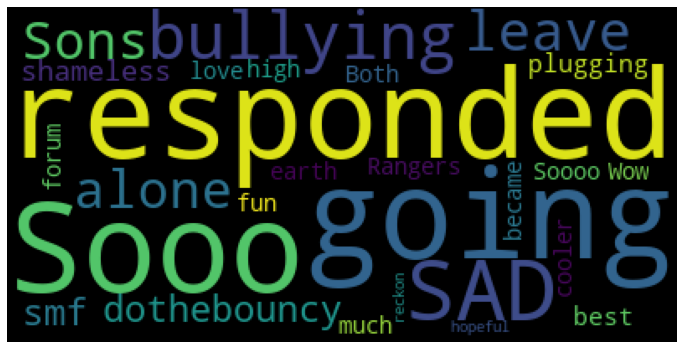

In [41]:
# All training selected_text
print('Word Cloud for selected_text in training data')
train_selected_text = plot_word_cloud(train, 'selected_text')

In [42]:
train_selected_text

['I`d',
 'have',
 'responded,',
 'if',
 'I',
 'were',
 'going',
 'Sooo',
 'SAD',
 'bullying',
 'me',
 'leave',
 'me',
 'alone',
 'Sons',
 'of',
 '****,',
 'http://www.dothebouncy.com/smf',
 '-',
 'some',
 'shameless',
 'plugging',
 'for',
 'the',
 'best',
 'Rangers',
 'forum',
 'on',
 'earth',
 'fun',
 'Soooo',
 'high',
 'Both',
 'of',
 'you',
 'Wow...',
 'u',
 'just',
 'became',
 'cooler.',
 'as',
 'much',
 'as',
 'i',
 'love',
 'to',
 'be',
 'hopeful,',
 'i',
 'reckon']

Word Cloud for Outliers


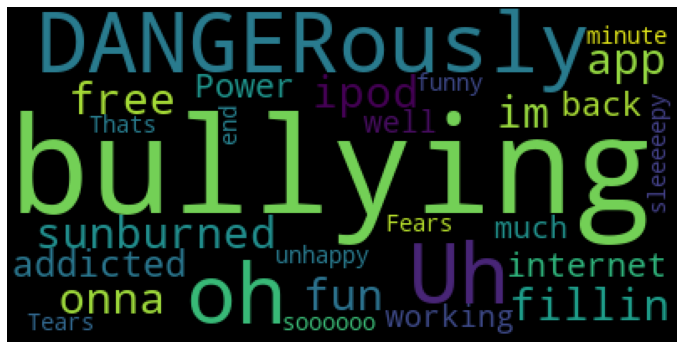

In [43]:
# Oitlier WordCloud
print('Word Cloud for Outliers')
outlier_max = plot_word_cloud(train_outlier, 'selected_text')

In [44]:
outlier_max

['bullying',
 'me',
 'DANGERously',
 'Uh',
 'oh,',
 'I',
 'am',
 'sunburned',
 'onna',
 'the',
 'free',
 'fillin`',
 'app',
 'on',
 'my',
 'ipod',
 'is',
 'fun,',
 'im',
 'addicted',
 '.no',
 'internet',
 'Power',
 'back',
 'up',
 'not',
 'working',
 'too',
 'well',
 'so',
 'much',
 'for',
 'being',
 'unhappy',
 'for',
 'about',
 '10',
 'minute',
 'funny.',
 'Thats',
 'it,',
 'its',
 'the',
 'end.',
 'Tears',
 'for',
 'Fears',
 'soooooo',
 'sleeeeepy!!!',
 'A']

Word Cloud for the 100 worst outliers


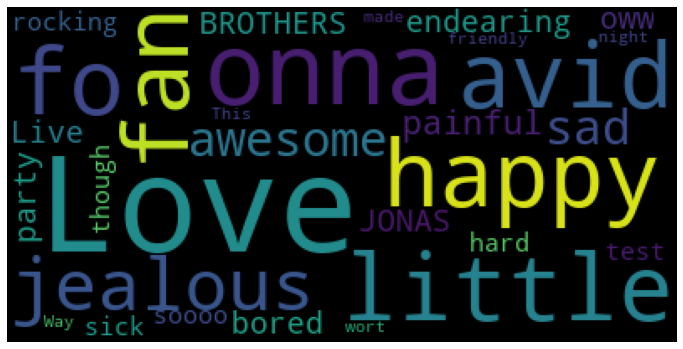

In [45]:
# Worst oitlier WordCloud
print('Word Cloud for the 100 worst outliers')
outlier_max100 = plot_word_cloud(train_outlier.nsmallest(100, 'metric', keep='all'), 'selected_text')

In [46]:
outlier_max100

['onna',
 'A',
 'little',
 'happy',
 'fo',
 'avid',
 'fan',
 'of',
 'jealous..',
 's',
 'awesome',
 'Love',
 'it',
 'there',
 'sad.',
 'painful.',
 'endearing-',
 'oww',
 'bored..',
 'JONAS',
 'BROTHERS',
 '-',
 'Live',
 'to',
 'party.',
 'It`s',
 'rocking',
 'so',
 'hard',
 'would',
 'love',
 'to',
 'test',
 'it',
 'though.',
 'sick.',
 ',',
 'he',
 'was',
 'soooo',
 'friendly.',
 'as',
 'wort',
 'This',
 'has',
 'made',
 'my',
 'night!!',
 'Way',
 'too']

Word Cloud for the 1000 worst outliers


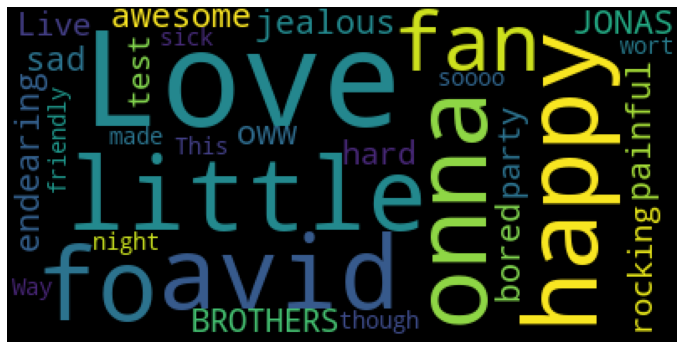

In [47]:
# Worst oitlier WordCloud
print('Word Cloud for the 1000 worst outliers')
outlier_max1000 = plot_word_cloud(train_outlier.nsmallest(1000, 'metric', keep='all'), 'selected_text')

In [48]:
outlier_max1000

['onna',
 'A',
 'little',
 'happy',
 'fo',
 'avid',
 'fan',
 'of',
 'jealous..',
 's',
 'awesome',
 'Love',
 'it',
 'there',
 'sad.',
 'painful.',
 'endearing-',
 'oww',
 'bored..',
 'JONAS',
 'BROTHERS',
 '-',
 'Live',
 'to',
 'party.',
 'It`s',
 'rocking',
 'so',
 'hard',
 'would',
 'love',
 'to',
 'test',
 'it',
 'though.',
 'sick.',
 ',',
 'he',
 'was',
 'soooo',
 'friendly.',
 'as',
 'wort',
 'This',
 'has',
 'made',
 'my',
 'night!!',
 'Way',
 'too']

Word Cloud for good prediction


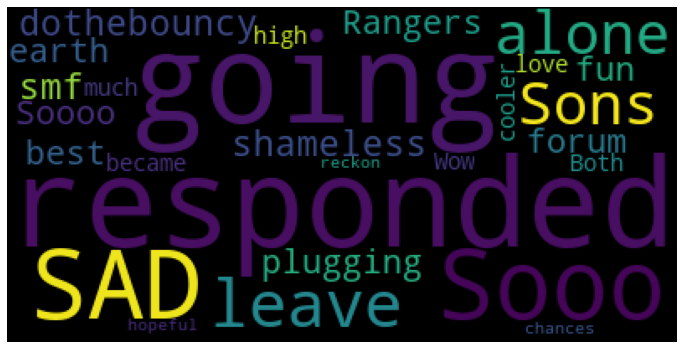

In [49]:
# Good prediction WordCloud
print('Word Cloud for good prediction')
good_max = plot_word_cloud(train_good, 'selected_text')

In [50]:
good_max

['I`d',
 'have',
 'responded,',
 'if',
 'I',
 'were',
 'going',
 'Sooo',
 'SAD',
 'leave',
 'me',
 'alone',
 'Sons',
 'of',
 '****,',
 'http://www.dothebouncy.com/smf',
 '-',
 'some',
 'shameless',
 'plugging',
 'for',
 'the',
 'best',
 'Rangers',
 'forum',
 'on',
 'earth',
 'fun',
 'Soooo',
 'high',
 'Both',
 'of',
 'you',
 'Wow...',
 'u',
 'just',
 'became',
 'cooler.',
 'as',
 'much',
 'as',
 'i',
 'love',
 'to',
 'be',
 'hopeful,',
 'i',
 'reckon',
 'the',
 'chances']

## 5.3. Subtext analysis <a class="anchor" id="5.3"></a>

[Back to Table of Contents](#0.1)

In [51]:
def subtext_analysis(col, subtext, df1, str1, df2, str2):
    # Calc statistics as table for subtext in the df1[col] (smaller) in compare to df2[col] (bigger) 
    
    result = pd.DataFrame(columns = ['subtext', str1, str2, 'share,%'])
    if (len(df1) > 0) and (len(df2) > 0):
        for i in range(len(subtext)):
            result.loc[i,'subtext'] = subtext[i]
            num1 = len(df1[df1[col].str.find(subtext[i]) > -1])
            result.loc[i, str1] = num1
            num2 = len(df2[df2[col].str.find(subtext[i]) > -1])
            result.loc[i, str2] = num2
            result.loc[i,'share,%'] = round(num1*100/num2,1) if num2 != 0 else 0
    print('Number of all data is', len(df2))
    display(result.sort_values(by=['share,%', str1], ascending=False))

In [52]:
def subtext_analysis_one_df(col, subtext, df, str):
    # Calc statistics as table for subtext in the df[col]
    
    result = pd.DataFrame(columns = ['subtext', str, 'share of all,%'])
    num_all = len(df)
    if (num_all > 0):
        for i in range(len(subtext)):
            result.loc[i,'subtext'] = subtext[i]
            num = len(df[df[col].str.find(subtext[i]) > -1])
            result.loc[i, str] = num
            result.loc[i,'share of all,%'] = round(num*100/num_all,1)
    print('Number of all data is', len(df))
    display(result.sort_values(by='share of all,%', ascending=False))    

In [53]:
subtext_test = ['SAD', 'bullying', 'Uh', 'oh', 'onna', 'fun', 'addicted', 'Power', 'well', 'unhappy', 'funny', 'Tears', 'Fears', 'sleeeeepy', ' ', ',', '?', '!' ,'!!', '!!!', ':/', '...', 'http', '****']

In [54]:
subtext_analysis("selected_text", subtext_test, train_outlier, 'train_outliers', train, 'train_all')

Number of all data is 27481


,subtext,train_outliers,train_all,"share,%"
1,bullying,1,1,100
11,Tears,1,1,100
12,Fears,1,1,100
13,sleeeeepy,1,1,100
9,unhappy,5,8,62.5
10,funny,50,103,48.5
5,fun,266,556,47.8
23,****,256,609,42
14,,8066,20606,39.1
17,!,1702,4968,34.3


There are problems in processing: "!", "!!", "!!!", ":/", "...", "http" etc.

In [55]:
subtext_analysis("selected_text", subtext_test, train_good, 'train_good', train, 'train_all')

Number of all data is 27481


,subtext,train_good,train_all,"share,%"
0,SAD,10,11,90.9
22,http,300,352,85.2
20,:/,309,366,84.4
16,?,1391,1694,82.1
21,...,1441,1857,77.6
4,onna,151,209,72.2
3,oh,215,299,71.9
19,!!!,329,458,71.8
8,well,239,334,71.6
2,Uh,5,7,71.4


In [56]:
subtext_analysis_one_df("selected_text", subtext_test, train, 'test_all')

Number of all data is 27481


,subtext,test_all,"share of all,%"
14,,20606,75
17,!,4968,18.1
15,",",3631,13.2
21,...,1857,6.8
16,?,1694,6.2
18,!!,1085,3.9
23,****,609,2.2
5,fun,556,2
19,!!!,458,1.7
22,http,352,1.3


In [57]:
subtext_analysis_one_df("selected_text", subtext_test, test, 'test_all')

Number of all data is 3534


,subtext,test_all,"share of all,%"
14,,3515,99.5
17,!,612,17.3
15,",",445,12.6
21,...,277,7.8
16,?,214,6.1
18,!!,140,4
20,:/,76,2.2
19,!!!,73,2.1
23,****,72,2
22,http,72,2


In [58]:
test['text_chr3'] = test['text'].apply(rep_3chr)
test.head(10)

,textID,text,sentiment,selected_text,text_chr3
0,f87dea47db,Last session of the day http://twit...,neutral,last session of the day http://twit...,0
1,96d74cb729,Shanghai is also really exciting (p...,positive,exciting,0
2,eee518ae67,"Recession hit Veronique Branquinho, ...",negative,such a shame!,0
3,01082688c6,happy bday!,positive,happy bday!,0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it!!,0
5,726e501993,that`s great!! weee!! visitors!,positive,that`s great!!,1
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,hates,0
7,afa11da83f,"soooooo wish i could, but im in sch...",negative,blocked,1
8,e64208b4ef,and within a short time of the last...,neutral,and within a short time of the last...,0
9,37bcad24ca,What did you get? My day is alrigh...,neutral,what did you get? my day is alright...,0


In [59]:
test.describe()

,text_chr3
count,3534.000000
mean,0.258630
std,0.437944
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 5.4. Metric analysis <a class="anchor" id="5.4"></a>

[Back to Table of Contents](#0.1)

Metric of prediction for training data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd80b5150>]],
      dtype=object)

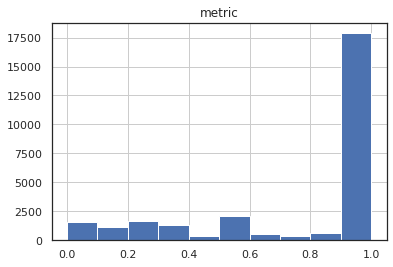

In [60]:
print('Metric of prediction for training data')
train[['metric']].hist(bins=10)

Metric of prediction for outliers of training data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd7a2ac90>]],
      dtype=object)

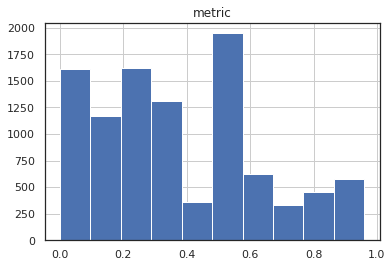

In [61]:
print('Metric of prediction for outliers of training data')
train_outlier[['metric']].hist(bins=10)

In [62]:
train_outlier1 = train_outlier.nsmallest(1000, 'metric', keep='all')
train_outlier2 = train_outlier.nsmallest(2000, 'metric', keep='all')
train_outlier3 = train_outlier.nsmallest(3000, 'metric', keep='all')
train_outlier5 = train_outlier.nsmallest(5000, 'metric', keep='all')
train_outlier8 = train_outlier.nsmallest(8000, 'metric', keep='all')

In [63]:
subtext_analysis("selected_text", subtext_test, train_outlier1, 'in worst 1000 outliers', train_outlier, 'in all outliers')

Number of all data is 9993


,subtext,in worst 1000 outliers,in all outliers,"share,%"
10,funny,6,50,12
18,!!,43,360,11.9
5,fun,26,266,9.8
17,!,164,1702,9.6
8,well,9,95,9.5
23,****,22,256,8.6
21,...,34,416,8.2
16,?,24,303,7.9
14,,545,8066,6.8
15,",",71,1042,6.8


In [64]:
subtext_analysis("selected_text", subtext_test, train_outlier2, 'in worst 2000 outliers', train_outlier, 'in all outliers')

Number of all data is 9993


,subtext,in worst 2000 outliers,in all outliers,"share,%"
6,addicted,2,3,66.7
9,unhappy,2,5,40
18,!!,107,360,29.7
3,oh,24,84,28.6
23,****,71,256,27.7
21,...,111,416,26.7
15,",",274,1042,26.3
4,onna,15,58,25.9
17,!,420,1702,24.7
19,!!!,31,129,24


In [65]:
subtext_analysis("selected_text", subtext_test, train_outlier3, 'in worst 3000 outliers', train_outlier, 'in all outliers')

Number of all data is 9993


,subtext,in worst 3000 outliers,in all outliers,"share,%"
6,addicted,2,3,66.7
9,unhappy,3,5,60
2,Uh,1,2,50
3,oh,40,84,47.6
18,!!,152,360,42.2
23,****,102,256,39.8
21,...,161,416,38.7
17,!,656,1702,38.5
15,",",393,1042,37.7
4,onna,21,58,36.2


In [66]:
subtext_analysis("selected_text", subtext_test, train_outlier5, 'in worst 5000 outliers', train_outlier, 'in all outliers')

Number of all data is 9993


,subtext,in worst 5000 outliers,in all outliers,"share,%"
1,bullying,1,1,100
9,unhappy,4,5,80
6,addicted,2,3,66.7
10,funny,31,50,62
3,oh,50,84,59.5
5,fun,156,266,58.6
18,!!,210,360,58.3
23,****,147,256,57.4
17,!,973,1702,57.2
14,,4329,8066,53.7


In [67]:
subtext_analysis("selected_text", subtext_test, train_outlier8, 'in worst 8000 outliers', train_outlier, 'in all outliers')

Number of all data is 9993


,subtext,in worst 8000 outliers,in all outliers,"share,%"
6,addicted,3,3,100
0,SAD,1,1,100
1,bullying,1,1,100
11,Tears,1,1,100
12,Fears,1,1,100
10,funny,43,50,86
5,fun,222,266,83.5
9,unhappy,4,5,80
23,****,199,256,77.7
14,,6089,8066,75.5


In [68]:
train_outlier1.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.0,1023.000000,1023.000000,1023.000000
mean,0.092864,11.361681,15.372434,10.383187,13.109482,82.156403,18.368524,4.010753,0.227633,12.281525,2.726295,0.179260,0.168133,0.002651,0.0,0.478983,0.086999,0.274682
std,0.992229,8.501190,9.584167,8.846583,11.250298,34.266781,28.196162,6.990830,0.256967,18.303992,8.427622,0.217148,0.374167,0.010374,0.0,0.499802,0.281971,0.446572
min,-1.000000,2.000000,2.000000,0.000000,2.000000,9.000000,1.000000,0.000000,0.008929,3.000000,0.000000,0.021739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-1.000000,4.000000,8.000000,2.000000,5.000000,53.000000,6.000000,1.000000,0.071429,5.000000,0.000000,0.061901,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,9.000000,13.000000,7.000000,10.000000,83.000000,8.000000,1.000000,0.123967,8.000000,1.000000,0.104762,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.000000,17.000000,22.000000,15.000000,18.000000,114.000000,15.000000,4.000000,0.258578,11.000000,2.000000,0.188090,0.000000,0.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,48.000000,49.000000,42.000000,127.000000,138.000000,138.000000,38.000000,1.000000,136.000000,127.000000,1.000000,1.000000,0.045455,0.0,1.000000,1.000000,1.000000


In [69]:
train_outlier2.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.0,2052.000000,2052.000000,2052.000000
mean,0.092105,8.981969,17.190058,9.593567,13.844055,84.276803,35.642788,8.208090,0.434954,17.435185,4.250487,0.225272,0.083821,0.046201,0.0,0.395712,0.137914,0.194444
std,0.992314,8.185571,9.223956,8.303455,12.644332,31.666756,36.419700,9.134035,0.386816,25.572512,11.535104,0.289179,0.277186,0.047500,0.0,0.489122,0.344894,0.395869
min,-1.000000,2.000000,2.000000,0.000000,2.000000,9.000000,1.000000,0.000000,0.008929,3.000000,0.000000,0.021739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,10.000000,2.000000,6.000000,58.000000,6.000000,1.000000,0.085444,5.000000,0.000000,0.058333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,6.000000,16.000000,7.000000,11.000000,84.000000,15.000000,3.000000,0.250000,7.000000,1.000000,0.094666,0.000000,0.047619,0.0,0.000000,0.000000,0.000000
75%,1.000000,14.000000,24.000000,14.000000,19.000000,113.000000,57.000000,14.000000,0.969347,13.000000,3.000000,0.202680,0.000000,0.090909,0.0,1.000000,0.000000,0.000000
max,1.000000,48.000000,49.000000,42.000000,138.000000,138.000000,138.000000,38.000000,1.000000,138.000000,138.000000,1.000000,1.000000,0.125000,0.0,1.000000,1.000000,1.000000


In [70]:
train_outlier3.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.0,3311.000000,3311.000000,3311.000000
mean,0.114769,8.830263,16.326185,9.699789,13.673513,80.438538,33.071580,7.495923,0.445053,17.197523,3.973724,0.237285,0.052552,0.095359,0.0,0.359106,0.127454,0.156448
std,0.988818,8.045464,8.992943,8.277980,11.944965,32.932363,31.768355,7.996935,0.367843,24.147187,10.516664,0.288509,0.223171,0.074453,0.0,0.479811,0.333531,0.363335
min,-1.000000,2.000000,2.000000,0.000000,2.000000,9.000000,1.000000,0.000000,0.008929,2.000000,0.000000,0.021739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,9.000000,2.000000,6.000000,53.000000,7.000000,1.000000,0.106383,5.000000,0.000000,0.063110,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,6.000000,15.000000,7.000000,11.000000,79.000000,25.000000,5.000000,0.305556,7.000000,1.000000,0.108108,0.000000,0.100000,0.0,0.000000,0.000000,0.000000
75%,1.000000,13.000000,22.000000,14.000000,19.000000,110.000000,47.000000,11.000000,0.911810,15.000000,3.000000,0.234994,0.000000,0.166667,0.0,1.000000,0.000000,0.000000
max,1.000000,48.000000,52.000000,53.000000,138.000000,138.000000,138.000000,40.000000,1.000000,138.000000,138.000000,1.000000,1.000000,0.200000,0.0,1.000000,1.000000,1.000000


In [71]:
train_outlier5.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,5614.000000,5614.000000,5614.000000,5614.000000,5614.000000,5614.000000,5614.000000,5614.000000,5614.000000,5614.000000,5614.00000,5614.000000,5614.000000,5614.000000,5614.0,5614.000000,5614.000000,5614.000000
mean,0.104204,8.568757,14.705736,9.299430,12.836480,75.500178,27.648201,6.136979,0.411763,16.170645,3.53705,0.244671,0.046491,0.176824,0.0,0.324190,0.109904,0.130566
std,0.987724,7.840870,8.843553,7.970501,10.898622,34.076432,27.568331,6.975430,0.344255,22.325709,9.02758,0.278763,0.210564,0.116305,0.0,0.468113,0.312798,0.336956
min,-1.000000,2.000000,2.000000,0.000000,2.000000,9.000000,1.000000,0.000000,0.008929,2.000000,0.00000,0.016949,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,7.000000,2.000000,5.000000,47.000000,8.000000,1.000000,0.125000,5.000000,0.00000,0.069341,0.000000,0.076923,0.0,0.000000,0.000000,0.000000
50%,1.000000,6.000000,13.000000,7.000000,10.000000,73.000000,18.000000,4.000000,0.277778,8.000000,1.00000,0.125000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000
75%,1.000000,13.000000,20.000000,14.000000,18.000000,104.000000,35.000000,8.000000,0.683991,15.000000,3.00000,0.275172,0.000000,0.250000,0.0,1.000000,0.000000,0.000000
max,1.000000,48.000000,52.000000,53.000000,138.000000,138.000000,138.000000,40.000000,1.000000,138.000000,138.00000,1.000000,1.000000,0.333333,0.0,1.000000,1.000000,1.000000


In [72]:
train_outlier8.describe()

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,len_selected_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,selected_text_chr3,selected_text_pred_chr3
count,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8015.000000,8016.000000,8016.000000,8015.000000,8016.000000,8016.000000,8016.0,8016.000000,8016.000000,8016.000000
mean,0.089696,8.774701,14.093937,9.239895,12.774701,73.883608,24.381238,5.319237,0.376035,16.431761,3.534805,0.258631,0.037924,0.269184,0.0,0.312500,0.098678,0.120883
std,0.984756,7.852676,8.835534,7.957746,10.424425,34.523131,25.410646,6.475965,0.328669,22.167504,8.360919,0.282366,0.191025,0.173053,0.0,0.463541,0.298247,0.326012
min,-1.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.008929,0.000000,0.000000,0.016949,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,-1.000000,2.000000,7.000000,2.000000,5.000000,45.000000,7.000000,1.000000,0.112500,5.000000,0.000000,0.073171,0.000000,0.125000,0.0,0.000000,0.000000,0.000000
50%,1.000000,6.000000,12.000000,7.000000,10.000000,71.000000,16.000000,3.000000,0.250000,8.000000,1.000000,0.136364,0.000000,0.250000,0.0,0.000000,0.000000,0.000000
75%,1.000000,13.000000,20.000000,14.000000,18.000000,103.000000,31.000000,7.000000,0.542615,16.000000,3.000000,0.311475,0.000000,0.444444,0.0,1.000000,0.000000,0.000000
max,1.000000,48.000000,52.000000,53.000000,138.000000,139.000000,138.000000,40.000000,1.000000,138.000000,138.000000,1.000000,1.000000,0.571429,0.0,1.000000,1.000000,1.000000


In [73]:
# Histograms of interesting features in training data
col_hist = ['sentiment', 'start', 'end', 'start_pred', 'end_pred', 'len_text', 'len_selected_text', 
            'text_chr3', 'selected_text_chr3', 'selected_text_pred_chr3', 'metric']

Statistics for 1000 worst outliers


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


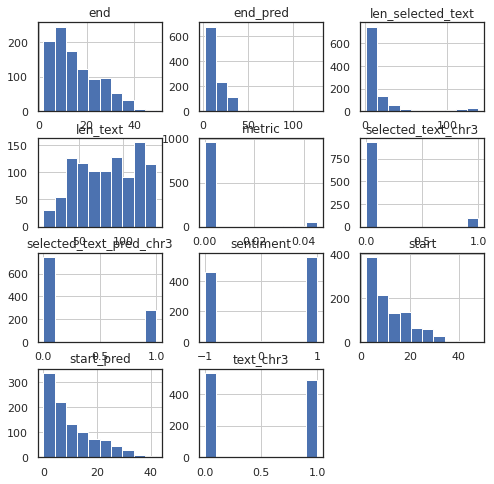

In [74]:
print('Statistics for 1000 worst outliers')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train_outlier1[col_hist].hist(ax=ax)
plt.show()

Statistics for 2000 worst outliers


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


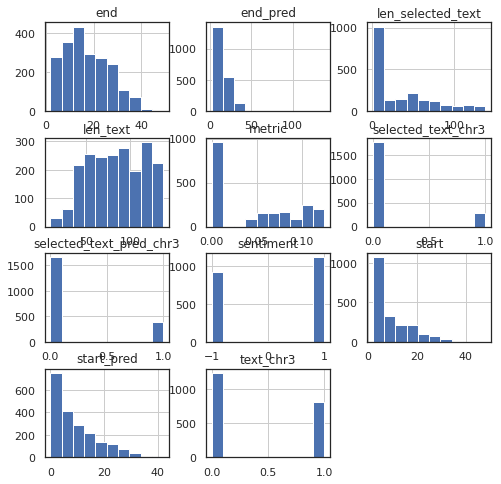

In [75]:
print('Statistics for 2000 worst outliers')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train_outlier2[col_hist].hist(ax=ax)
plt.show()

Statistics for 3000 worst outliers


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


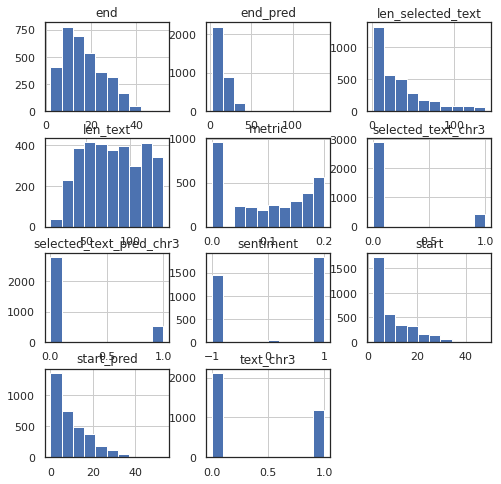

In [76]:
print('Statistics for 3000 worst outliers')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train_outlier3[col_hist].hist(ax=ax)
plt.show()

Statistics for 5000 worst outliers


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


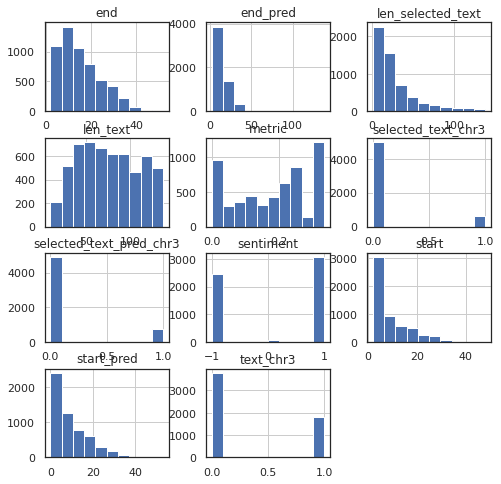

In [77]:
print('Statistics for 5000 worst outliers')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train_outlier5[col_hist].hist(ax=ax)
plt.show()

Statistics for 8000 worst outliers


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


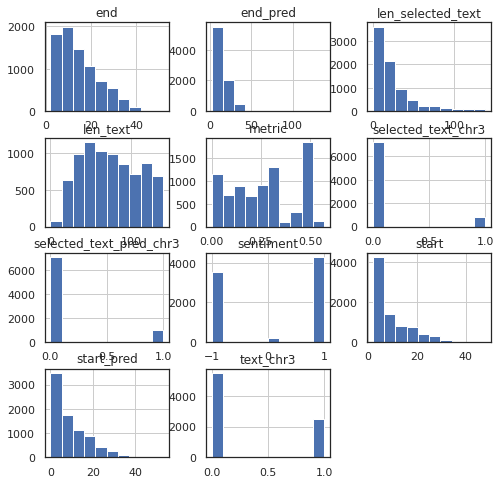

In [78]:
print('Statistics for 8000 worst outliers')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
train_outlier8[col_hist].hist(ax=ax)
plt.show()

## 5.5. PCA visualization <a class="anchor" id="5.5"></a>

[Back to Table of Contents](#0.1)

Using my notebook https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

In [79]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True, title=None):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.title(title)
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Good')
            blue_patch = mpatches.Patch(color='blue', label='Outlier')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

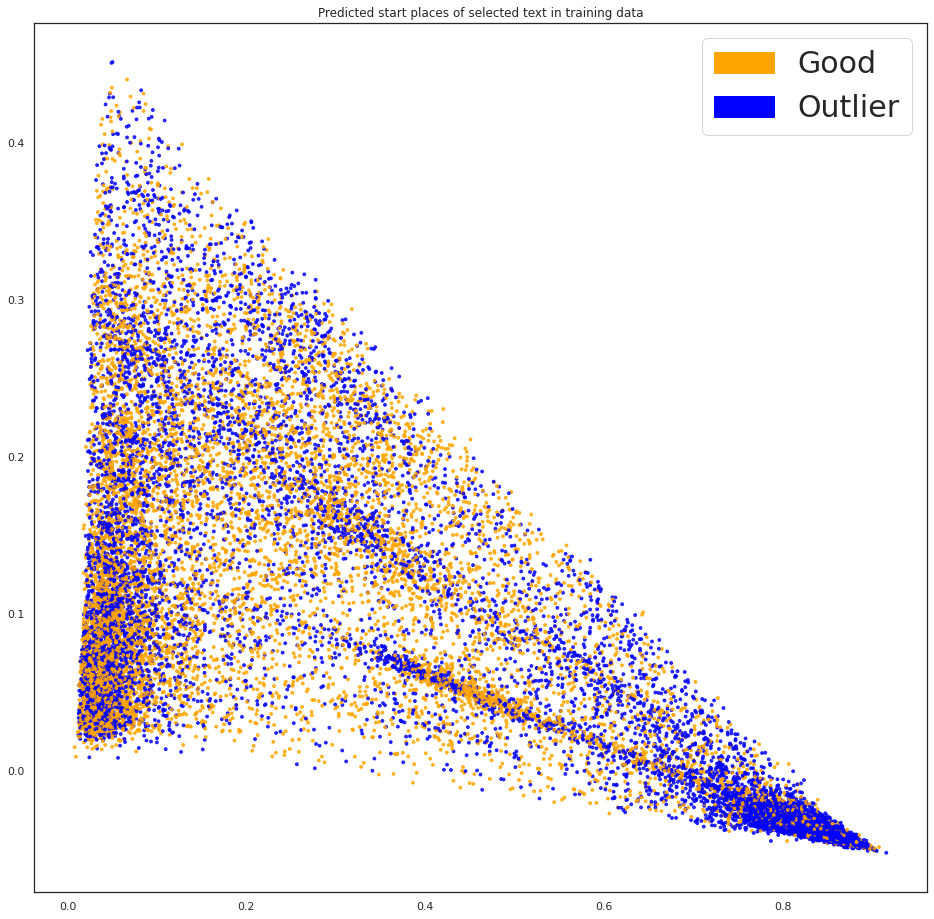

In [80]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(preds_start_train, train['res'], title='Predicted start places of selected text in training data')
plt.show()

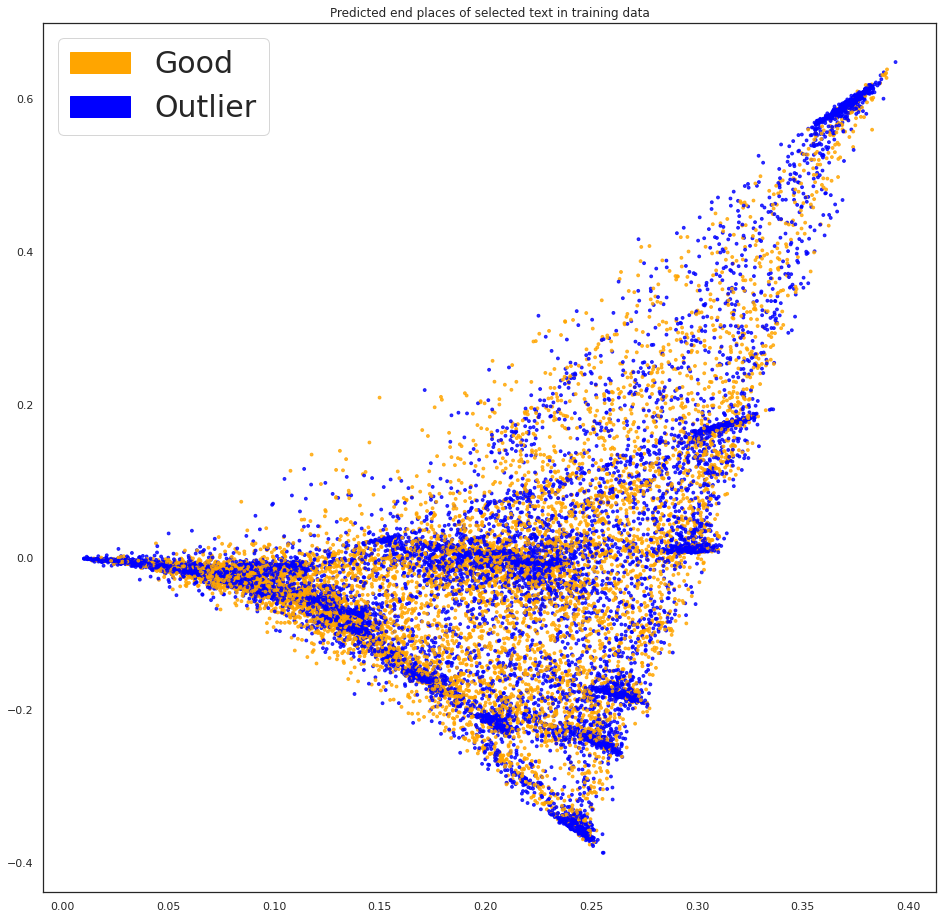

In [81]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(preds_end_train, train['res'], title='Predicted end places of selected text in training data')
plt.show()

There are a number of clear patterns that allow us to hope that we can improve the solution.

## 5.6. Clustering <a class="anchor" id="5.6"></a>

[Back to Table of Contents](#0.1)

Using my notebook https://www.kaggle.com/vbmokin/covid-19-week5-global-forecasting-eda-extratr

In [82]:
data = train[['sentiment', 'start', 'end', 'start_pred', 'end_pred', 'len_text', 'len_selected_text', 'diff_num', 'share', 'metric', 'res']].dropna()
data

,sentiment,start,end,start_pred,end_pred,len_text,len_selected_text,diff_num,share,metric,res
0,0,2,11,2,11,36,35,9,0.972222,1.000000,1
1,-1,2,4,2,4,46,8,2,0.173913,1.000000,1
2,-1,5,6,5,7,25,11,1,0.440000,0.333333,0
3,-1,5,7,5,7,31,14,2,0.451613,1.000000,1
4,-1,2,5,2,5,75,13,3,0.173333,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
27476,-1,11,12,12,12,77,6,1,0.077922,0.500000,0
27477,-1,19,23,20,23,122,13,4,0.106557,0.666667,0
27478,1,2,9,2,4,111,25,7,0.225225,0.333333,0
27479,1,2,8,5,5,27,26,6,0.962963,0.200000,0


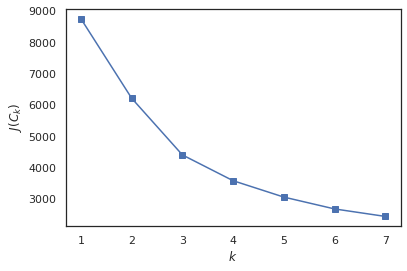

In [83]:
# Thanks to https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering
inertia = []
pca = PCA(n_components=2)
# fit X and apply the reduction to X 
x_3d = pca.fit_transform(data)
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x_3d)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

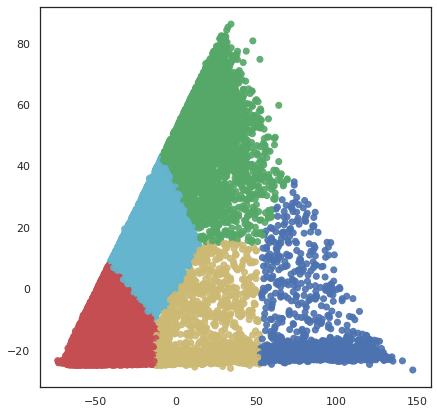

In [84]:
# Thanks to https://www.kaggle.com/arthurtok/a-cluster-of-colors-principal-component-analysis
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_3d)
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'y',
                   4 : 'c'}

label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]
plt.figure(figsize = (7,7))
plt.scatter(x_3d[:,0],x_3d[:,1], c= label_color, alpha=0.9)
plt.show()

There are a number of clear clusters that allow us to hope that we can improve the solution.

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)